In [0]:
import sys
import os
path = ''
sys_path = os.path.join(path)
sys.path.append(sys_path)

import numpy as np
from matplotlib import pyplot
import matplotlib as mpl
from scipy import optimize 
from scipy.io import loadmat # load MATLAB mat datafile format
import utils # library written for this exercise providing additional functions

# tells matplotlib to embed plots within the notebook
%matplotlib inline 

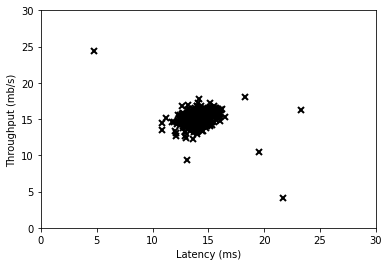

In [11]:
### TASK1: Abnomaly Detection ###
### Detect anomalous behavior in server computers. The features are throughput (mb/s) and latency (ms) of response of each server.

# Load & visualize data
data = loadmat(os.path.join(prefix, customized_path_to_your_homework, 'Data', 'ex8data1.mat'))
X, Xval, yval = data['X'], data['Xval'], data['yval'][:, 0]

pyplot.plot(X[:, 0], X[:, 1], 'bx', mew=2, mec='k', ms=6)
pyplot.axis([0, 30, 0, 30])
pyplot.xlabel('Latency (ms)')
pyplot.ylabel('Throughput (mb/s)')
pass

In [0]:
# Func1: estimate gaussian distribution (mu, sigma**2)
def estimateGaussian(X):
    m, n = X.shape
    mu = np.zeros(n)
    sigma2 = np.zeros(n)
    mu = 1 / m * X.sum(axis=0)
    sigma2 = 1 / m * np.sum((X - mu)**2, axis = 0)
    return mu, sigma2

# Func2: select threshold (epsilon) by comparing F1 scores
def selectThreshold(yval, pval):
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0
   
    for epsilon in np.linspace(1.01*min(pval), max(pval), 1000):
        fp = np.sum((yval == 0) & (pval < epsilon))
        tp = np.sum((yval == 1) & (pval < epsilon))
        fn = np.sum((yval == 1) & (pval >= epsilon))
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        F1 = 2 * prec * rec / (prec + rec)
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon

    return bestEpsilon, bestF1

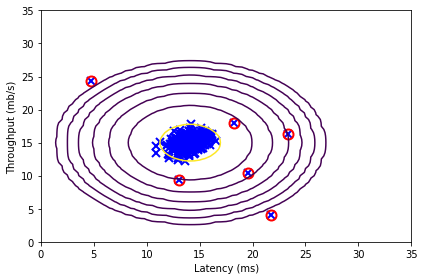

In [26]:
# estimate gaussian distribution (mu, sigma**2)
mu, sigma2 = estimateGaussian(X)

#  get the density of the multivariate normal at each data point from Training set
p = utils.multivariateGaussian(X, mu, sigma2)

# get the threshold (eplison) from Cross-validation set
pval = utils.multivariateGaussian(Xval, mu, sigma2)
epsilon, F1 = selectThreshold(yval, pval)

#  Find the outliers in the training set
outliers = p < epsilon

#  Visualize the result (Red circles for abnomalies)
utils.visualizeFit(X,  mu, sigma2)
pyplot.xlabel('Latency (ms)')
pyplot.ylabel('Throughput (mb/s)')
pyplot.tight_layout()
pyplot.plot(X[outliers, 0], X[outliers, 1], 'ro', ms=10, mfc='None', mew=2)
pass

In [0]:
### TASK2: Recommender Systems ###
### collaborative filtering learning algorithm

# Load data
### For a dataset of movie ratings ([MovieLens 100k Dataset](https://grouplens.org/datasets/movielens/) from GroupLens Research)
### This dataset consists of ratings on a scale of 1 to 5. The dataset has 943 users and 1,682 movies. 
data = loadmat(os.path.join(prefix, customized_path_to_your_homework, 'Data', 'ex8_movies.mat'))
Y, R = data['Y'], data['R']
# Y is raitings of 1682 movies on 94. users
# R is index having 1 if and only if user gave a rating to movie

# Example of get statistics (average rating)
# print('Average rating for movie 1 (Toy Story): %f / 5' %np.mean(Y[0, R[0, :] == 1]))

In [0]:
## func1: Collaborative filtering cost function: compute the cost function and gradient for collaborative filtering
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lambda_=0.0):
    
    # Unfold the U and W matrices from params
    X = params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)

    # Init.
    J = 0
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)

    # Cost Func
    J = 1 / 2 * np.sum(np.sum(R * (np.dot(X, Theta.T) - Y)**2))
    J = J + (lambda_ / 2 * np.sum(np.sum(Theta**2))) + (lambda_ / 2 * np.sum(np.sum(X**2)))

    # Gradient
    
    # movie
    for i in range (num_movies):
      idx = np.where(R[i, :] == 1)[0]
      Theta_temp = Theta[idx, :]
      Y_temp = Y[i, idx]
      X_grad[i, :] = np.dot(np.dot(X[i, :], Theta_temp.T) - Y_temp, Theta_temp)
      X_grad[i, :] = X_grad[i, :] + lambda_ * X[i,:]

    # user
    for j in range (num_users):
      idx = np.where(R[:, j] == 1)[0]
      X_temp = X[idx,:]
      Y_temp = Y[idx, j]
      Theta_grad[j,:] = np.dot(np.dot(X_temp, Theta[j,:].T) - Y_temp, X_temp)
      Theta_grad[j,:] = Theta_grad[j,:] + lambda_ * Theta[j,:]
          
    grad = np.concatenate([X_grad.ravel(), Theta_grad.ravel()])
    return J, grad

## func2: load the fixed movice list (a list of movie names)
def loadMovieList():
    with open(os.path.join(prefix, customized_path_to_your_homework, 'Data', 'movie_ids.txt'),  encoding='ISO-8859-1') as fid:
        movies = fid.readlines()

    movieNames = []
    for movie in movies:
        parts = movie.split()
        movieNames.append(' '.join(parts[1:]).strip())
    return movieNames

In [0]:
#  Check gradients by running checkcostFunction
# utils.checkCostFunction(cofiCostFunc)
# utils.checkCostFunction(cofiCostFunc, 1.5)

In [44]:
# Step1: add rating (a new user) 1 to 5 scales
movieList = loadMovieList()
n_m = len(movieList)
my_ratings = np.zeros(n_m)

my_ratings[0] = 4
my_ratings[97] = 2
my_ratings[6] = 3
my_ratings[11]= 5
my_ratings[53] = 4
my_ratings[63] = 5
my_ratings[65] = 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

print('New user ratings:')
print('-----------------')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d stars: %s' % (my_ratings[i], movieList[i]))

New user ratings:
-----------------
Rated 4 stars: Toy Story (1995)
Rated 3 stars: Twelve Monkeys (1995)
Rated 5 stars: Usual Suspects, The (1995)
Rated 4 stars: Outbreak (1995)
Rated 5 stars: Shawshank Redemption, The (1994)
Rated 3 stars: While You Were Sleeping (1995)
Rated 5 stars: Forrest Gump (1994)
Rated 2 stars: Silence of the Lambs, The (1991)
Rated 4 stars: Alien (1979)
Rated 5 stars: Die Hard 2 (1990)
Rated 5 stars: Sphere (1998)


In [49]:
# Step2: train the collaborative filtering model on a movie rating with dataset of 1682 movies and 943 users

#  Add new user
Y = np.hstack([my_ratings[:, None], Y])
R = np.hstack([(my_ratings > 0)[:, None], R])

#  Normalize Ratings
Ynorm, Ymean = utils.normalizeRatings(Y, R)

# Init (Random initializations)
num_movies, num_users = Y.shape
num_features = 10
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)
initial_parameters = np.concatenate([X.ravel(), Theta.ravel()])


options = {'maxiter': 100} # Set options (maxiter) for scipy.optimize.minimize
lambda_ = 10 # Set Regularization
result = optimize.minimize(lambda x: cofiCostFunc(x, Ynorm, R, num_users, num_movies, num_features, lambda_),
                        initial_parameters,
                        method='TNC',
                        jac=True,
                        options=options)
theta = result.x

print('====Training Completed====')

# Unfold the returned theta back into U and W
X = theta[:num_movies*num_features].reshape(num_movies, num_features)
Theta = theta[num_movies*num_features:].reshape(num_users, num_features)


Recommender system learning completed.


In [51]:
# make recommendations by computing the predictions matrix
p = np.dot(X, Theta.T)
my_predictions = p[:, 0] + Ymean
ix = np.argsort(my_predictions)[::-1]

print('Top recommendations for you:')
print('----------------------------')
for i in range(10):
    j = ix[i]
    print('Predicting rating %.1f for movie %s' % (my_predictions[j], movieList[j]))

print('\nOriginal ratings provided (new user):')
print('--------------------------')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d for %s' % (my_ratings[i], movieList[i]))

Top recommendations for you:
----------------------------
Predicting rating 5.0 for movie Santa with Muscles (1996)
Predicting rating 5.0 for movie Star Kid (1997)
Predicting rating 5.0 for movie They Made Me a Criminal (1939)
Predicting rating 5.0 for movie Great Day in Harlem, A (1994)
Predicting rating 5.0 for movie Prefontaine (1997)
Predicting rating 5.0 for movie Entertaining Angels: The Dorothy Day Story (1996)
Predicting rating 5.0 for movie Saint of Fort Washington, The (1993)
Predicting rating 5.0 for movie Someone Else's America (1995)
Predicting rating 5.0 for movie Marlene Dietrich: Shadow and Light (1996)
Predicting rating 5.0 for movie Aiqing wansui (1994)

Original ratings provided (new user):
--------------------------
Rated 4 for Toy Story (1995)
Rated 3 for Twelve Monkeys (1995)
Rated 5 for Usual Suspects, The (1995)
Rated 4 for Outbreak (1995)
Rated 5 for Shawshank Redemption, The (1994)
Rated 3 for While You Were Sleeping (1995)
Rated 5 for Forrest Gump (1994)
Rate